In [28]:
### Library Imports
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import itertools
import warnings
warnings.filterwarnings("ignore")

In [29]:
### Function to Import Rate Data
def import_fx_data(tickers, start_date):
    data = pd.DataFrame()
    if isinstance(tickers, str):
        tickers = [tickers]
        
    for ticker in tickers:
        data[ticker] = yf.download(ticker, start = start_date)['Adj Close']
        
    # Reset index to make headings in the same row
    data.reset_index(inplace = True)
    # Convert values in date col to dt
    data['Date'] = pd.to_datetime(data['Date'])

    return data

### Call Function to Load in Rate Data
forex_pairs = ['EURUSD=X', 'GBPUSD=X']
start_date = '2019-01-01'
forex_data = import_fx_data(forex_pairs, start_date)
forex_data.tail()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,EURUSD=X,GBPUSD=X
1423,2024-06-17,1.070217,1.268311
1424,2024-06-18,1.074068,1.271600
1425,2024-06-19,1.074229,1.270745
1426,2024-06-20,1.075153,1.272200
1427,2024-06-21,1.071811,1.266063


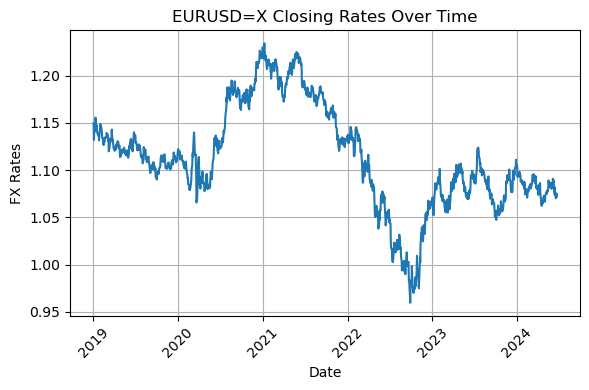

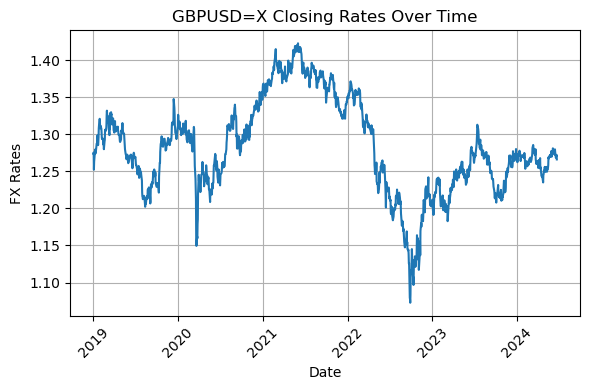

In [30]:
### Plot FX Rate Data
def plot_forex(df, forex_pairs):
    # Create Loop to Plot Each Individual FX Pair
    for pair in forex_pairs:
        plt.figure(figsize = (6, 4))

        plt.plot(df['Date'], df[pair]) # Need to adjust to spit out multiple graphs for each ticker
        plt.title(pair + ' Closing Rates Over Time')
        plt.xlabel('Date')
        plt.ylabel('FX Rates')

        plt.xticks(rotation = 45)  # Rotate x-axis labels for better readability
        plt.grid(True)
        plt.tight_layout()

    return plt.show()

### Return Function to Plot FX Pairs
plot_forex(forex_data, forex_pairs)


In [31]:
### Function to Compute Daily Returns
def daily_returns(fx_data):
    # Ensure 'Date' is set as the index for proper computation
    fx_data.set_index('Date', inplace=True)
    
    # Compute the daily returns of the forex data
    rets = fx_data.pct_change().dropna()
    
    # Reset index to make date a column again
    rets.reset_index(inplace=True)

    return rets

### Call Function to Calculate Daily Returns
daily_rets = daily_returns(forex_data)
print(daily_rets.head())


        Date  EURUSD=X  GBPUSD=X
0 2019-01-02 -0.002728  0.001275
1 2019-01-03 -0.012529 -0.018219
2 2019-01-04  0.006447  0.008537
3 2019-01-07  0.001700  0.008405
4 2019-01-08  0.006073  0.004015


In [32]:
### Function to Estimate the Beta Coefficient
'''
Beta is a measure of the sensitivity or volatility of an asset's returns in relation 
to the returns of a benchmark or market index. In the context of foreign exchange (FX) 
trading, beta represents how much the returns of one currency pair move in relation to 
the returns of another currency pair.
Beta = 1: The returns of the currency pair move in tandem with the benchmark. If the 
          benchmark's return increases by 1%, the currency pair's return also increases 
          by 1%, on average.

Beta > 1: The currency pair is more volatile than the benchmark. For example, if beta 
          is 1.5, then the currency pair's return is expected to increase by 1.5% for 
          every 1% increase in the benchmark's return, on average.

Beta < 1: The currency pair is less volatile than the benchmark. For example, if beta is 
          0.5, then the currency pair's return is expected to increase by 0.5% for every 
          1% increase in the benchmark's return, on average.

Beta = 0: There is no relationship between the currency pair's returns and the benchmark's returns.

Negative Beta: The currency pair moves in the opposite direction of the benchmark. For 
               example, if beta is -1, then the currency pair's return is expected to decrease
               by 1% for every 1% increase in the benchmark's return, on average.
'''
def get_beta(fx_rets, base_pair, benchmark_pair):
    # Get Base (first pair) and Benchmark (second pair) Returns 
    base_rets = fx_rets[base_pair]
    benchmark_rets = fx_rets[benchmark_pair]
    
    # Add a constant to the benchmark returns
    cons = sm.add_constant(benchmark_rets)
    # Run the OLS Regression
    model = sm.OLS(base_rets, cons).fit()
    # Extract the Beta Coefficient
    beta = model.params[1]

    return beta

### Function Call to Compute Beta
base_pair = 'EURUSD=X'
benchmark_pair = 'GBPUSD=X'
beta = get_beta(daily_rets, base_pair, benchmark_pair)
print('The computed Beta value is:', round(beta, 6))


The computed Beta value is: 0.524781
